# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-libraries" data-toc-modified-id="Load-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load libraries</a></div><div class="lev1 toc-item"><a href="#Define-loss-functions" data-toc-modified-id="Define-loss-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define loss functions</a></div><div class="lev1 toc-item"><a href="#Define-models" data-toc-modified-id="Define-models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define models</a></div><div class="lev1 toc-item"><a href="#Training" data-toc-modified-id="Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training</a></div><div class="lev1 toc-item"><a href="#Predictions" data-toc-modified-id="Predictions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Predictions</a></div>

# Load libraries

In [1]:
import cv2
import numpy as np
import pandas as pd

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.losses import binary_crossentropy
import keras.backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Define loss functions

In [2]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + (1 - dice_loss(y_true, y_pred))

def dice_loss_numpy(y_true, y_pred):
    return 2*np.sum(np.multiply(y_true, y_pred))/(np.sum(y_pred) + np.sum(y_true))

# Define models

In [3]:
def unet_down_one_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [4]:
def unet_max_pool(inputs):
    x = MaxPooling2D((2, 2), strides=(2, 2))(inputs)
    return x

In [5]:
def unet_up_one_block(up_input, down_input, num_filters):
    x = UpSampling2D((2,2))(up_input)
    x = concatenate([down_input, x], axis=3)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [6]:
def get_unet(input_shape = (256, 256, 3),
             num_classes = 1,
             initial_filters = 32,
             central_filters = 1024):
    
    num_filters = initial_filters
    
    out_list    = [Input(shape=input_shape)]
    down_interim_list = []
    
    while num_filters <= central_filters/2:
        x = unet_down_one_block(out_list[-1], num_filters)
        down_interim_list.append(x)
        num_filters = num_filters * 2
        y = unet_max_pool(x)
        out_list.append(y)
    
    x = unet_down_one_block(out_list[-1], num_filters)
    out_list.append(x)
    num_filters = int(num_filters / 2)
    
    while num_filters >= initial_filters:
        x = unet_up_one_block(out_list[-1], down_interim_list.pop(), num_filters)
        out_list.append(x)
        num_filters = int(num_filters / 2)
    
    classify = Conv2D(num_classes, (1,1), activation = 'sigmoid')(out_list[-1])
    
    model = Model(inputs=out_list[0], outputs=classify)
    
    model.compile(optimizer=RMSprop(lr=0.0001),
                  loss=bce_dice_loss,
                  metrics=[dice_loss])
    
    return model

In [7]:
model = get_unet(input_shape=(512,512,3), initial_filters=16)

In [8]:
model.load_weights('./weights/best_weights_512.hdf5')

# Training

In [9]:
df_train = pd.read_csv('data/train_masks.csv')

In [10]:
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [11]:
ids_train_split, ids_valid_split = train_test_split(ids_train, test_size=0.2, random_state=42)

In [28]:
batch_size=32
input_size=512
orig_width=1918
orig_height=1280

In [16]:
def valid_generator():
    while True:
        for start in range(0, len(ids_valid_split), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(ids_valid_split))
            ids_valid_batch = ids_valid_split[start:end]
            for id in ids_valid_batch.values:
                img = cv2.imread('data/train/{}.jpg'.format(id))
                img = cv2.resize(img, (input_size, input_size))
                mask = cv2.imread('data/train_masks/{}_mask.png'.format(id), cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (input_size, input_size))
                mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch

In [17]:
preds = model.predict_generator(valid_generator(), np.ceil(float(len(ids_valid_split)) / float(batch_size)))

In [19]:
preds = np.squeeze(preds, axis=3)

In [25]:
all_masks = []
for id in ids_valid_split.values:
    mask = cv2.imread('data/train_masks/{}_mask.png'.format(id), cv2.IMREAD_GRAYSCALE)/255
    all_masks.append(mask)

In [26]:
preds.shape

(1018, 512, 512)

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
def compute_dice_loss(threshold):
    loss_array = []
    for i in range(1018):
        tmp = np.copy(preds[i,:,:])
        tmp = cv2.resize(tmp, (orig_width, orig_height))
        tmp = (tmp > threshold).astype(int)
        loss_array.append(dice_loss_numpy(all_masks[i], tmp))
    return np.mean(np.array(loss_array))

In [51]:
mean_dice_loss = [compute_dice_loss(threshold) for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]

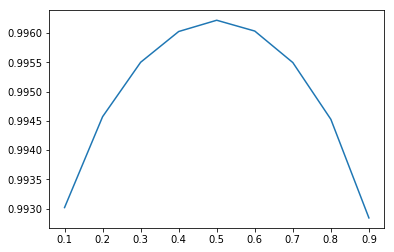

In [54]:
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], mean_dice_loss)

In [55]:
mean_dice_loss = [compute_dice_loss(threshold) for threshold in [0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55]]

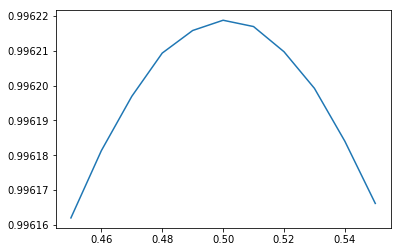

In [56]:
plt.plot([0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55], mean_dice_loss)